In [1]:
import numpy as np
import obspy
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
'''
folder_path = "C:/Users/twitt/BATE/BATE/Michigan/waveforms"
streams = []
# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file has a .mseed extension
    if filename.endswith(".mseed"):
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read the mseed file
            stream = obspy.read(file_path)
            streams.append(stream)
            # Process the stream (example: print basic info)
            print(f"Reading {filename}:")
            print(stream)
            print("------")
            
        except Exception as e:
            print(f"Error reading {filename}: {e}")'
'''

'\nfolder_path = "C:/Users/twitt/BATE/BATE/Michigan/waveforms"\nstreams = []\n# Iterate over all files in the folder\nfor filename in os.listdir(folder_path):\n    # Check if the file has a .mseed extension\n    if filename.endswith(".mseed"):\n        file_path = os.path.join(folder_path, filename)\n        \n        try:\n            # Read the mseed file\n            stream = obspy.read(file_path)\n            streams.append(stream)\n            # Process the stream (example: print basic info)\n            print(f"Reading {filename}:")\n            print(stream)\n            print("------")\n            \n        except Exception as e:\n            print(f"Error reading {filename}: {e}")\'\n'

In [3]:
name = "C:/Users/twitt/BATE/BATE/Michigan"
#st = obspy.read(name + "/waveforms/*.mseed")
st = obspy.read(name + "/waveforms/*.mseed")
inv = obspy.read_inventory(name + "/stations/*.xml")

In [4]:
print(inv)

Inventory created at 2025-04-06T20:32:26.701019Z
	Created by: ObsPy 1.4.1
		    https://www.obspy.org
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (8):
			N4 (6x), US, WU
		Stations (8):
			N4.I49A (Point Hope, MI, USA)
			N4.J47A (Sumner, MI, USA)
			N4.K50A (Casco, MI, USA)
			N4.L48A (N Adams, MI, USA)
			N4.M50A (Fremont, OH, USA)
			N4.N49A (Columbus Grove, OH, USA)
			US.AAM (Ann Arbor, Michigan, USA)
			WU.ELFO (Elginfield, Ontario, Canada)
		Channels (14):
			N4.I49A..HHZ, N4.I49A.EP.BDF, N4.J47A..HHZ, N4.J47A.EP.BDF, 
			N4.K50A..HHZ, N4.K50A.EP.BDF, N4.L48A..HHZ, N4.L48A.EP.BDF, 
			N4.M50A..HHZ, N4.M50A.EP.BDF, N4.N49A..HHZ, N4.N49A.EP.BDF, 
			US.AAM.00.BHZ, WU.ELFO..HHZ


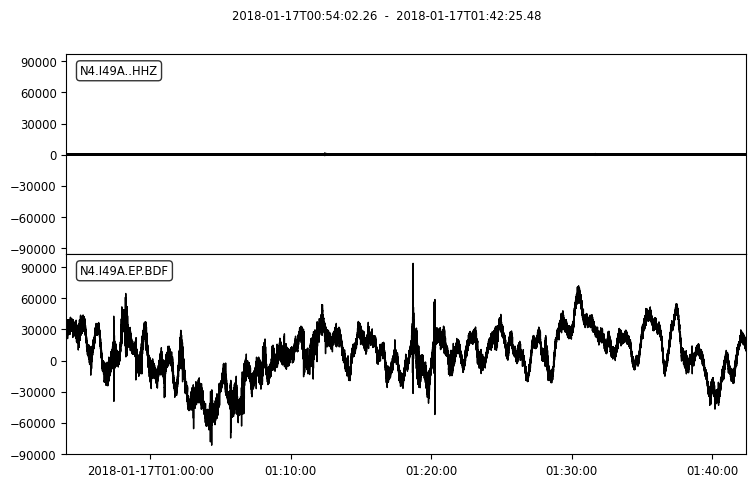

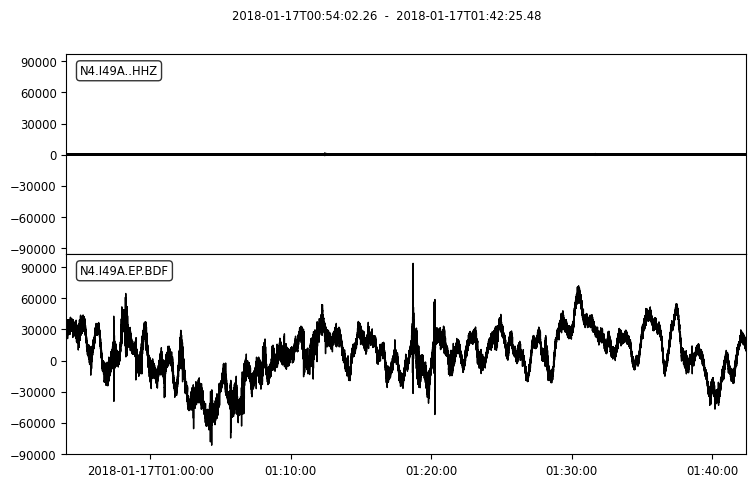

In [5]:
station = inv.select(station="I49A")
filtered_st = st.select(station="I49A")
station_codes = [network.stations[0].code for network in inv]  # For each network in the inventory
filtered_st.plot()

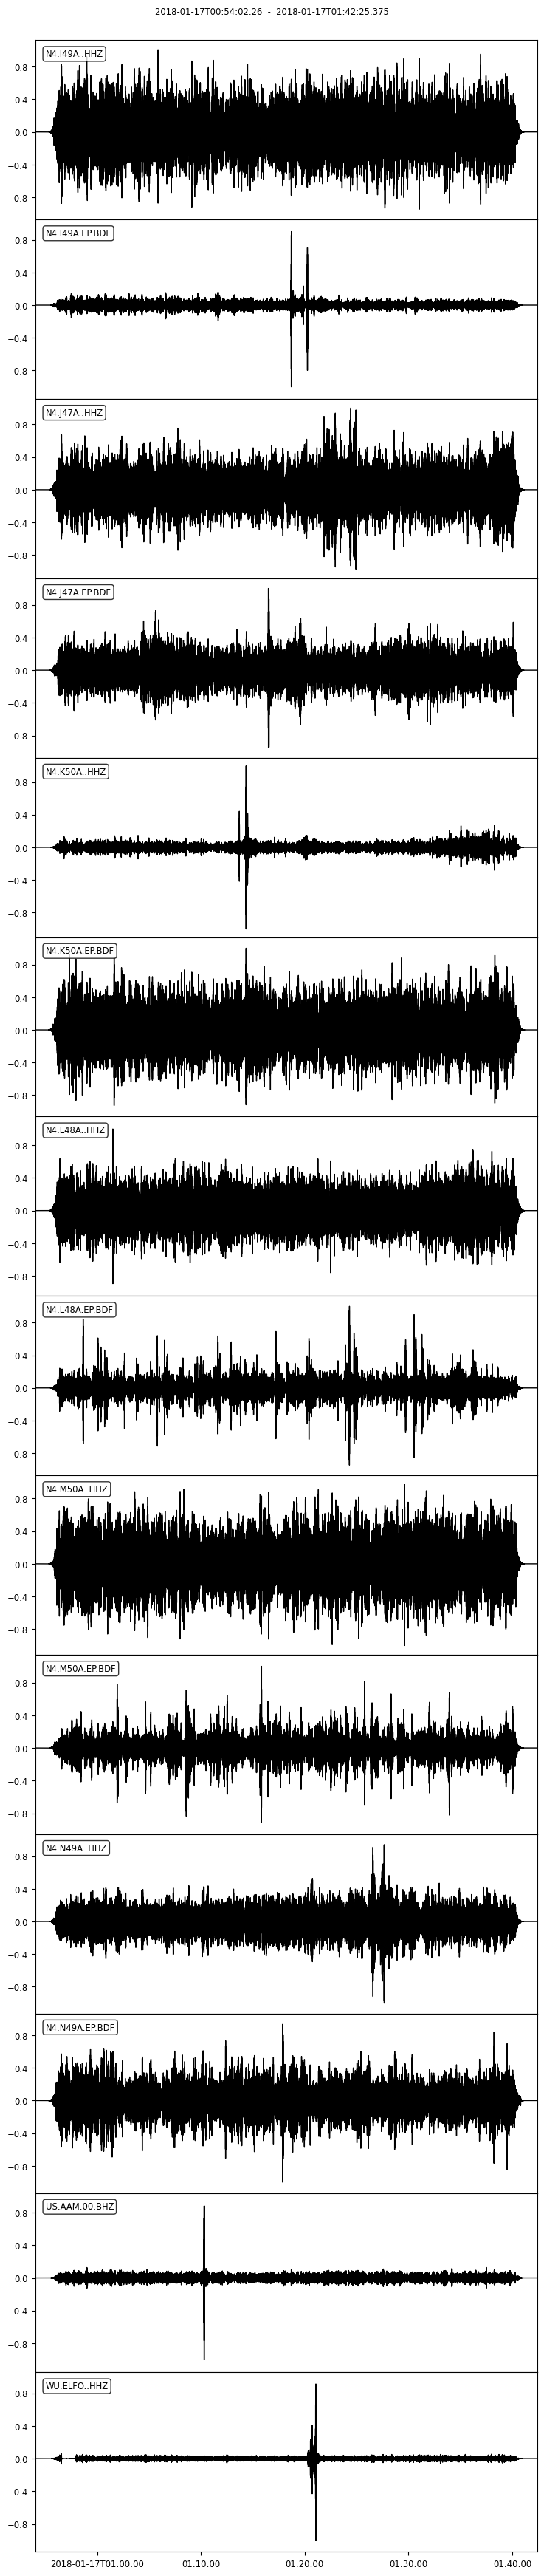

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [76]:
st.merge(fill_value='interpolate')
st.detrend('demean')
st.detrend('linear')
st.resample(10.0)
st.taper(0.05)
for trace in st:
    trace.filter('bandpass', freqmin=0.1,freqmax=3, corners = 4, zerophase = True)
    trace.normalize()
st.plot()
plt.tight_layout

In [68]:
time_delay = np.array([])  # Initialize an empty array for time delays
times_not = np.array([])
final_array = np.zeros((len(st),4))
ind = 0
start_time_array = np.zeros(0)
print(start_time_array)
for trace in st:
    times = trace.times()  # Get the time values for the trace
    datetime_times = [trace.stats.starttime + t for t in times]
    data = trace.data  # Get the data from the trace
    data = np.abs(data)  # Take the absolute value of the data
    index = np.argmax(data)  # Find the index of the maximum absolute value
    
    # Append the corresponding time to the time_delay array
    time_delay = np.append(time_delay, datetime_times[index])
    times_not = np.append(times_not, times[index])
    start_time_array = np.append(start_time_array, datetime_times[index])
    final_array[ind,3] = times[index]
    ind += 1


datetimes_as_int = start_time_array.astype('float')

# Calculate the average of the datetime values (in nanoseconds)
average_datetime_int = np.mean(datetimes_as_int)


average_datetime = obspy.UTCDateTime(average_datetime_int)

print(average_datetime)
print(start_time_array)

[]
2018-01-17T01:20:19.858643Z
[UTCDateTime(2018, 1, 17, 1, 36, 57, 960000)
 UTCDateTime(2018, 1, 17, 1, 20, 15, 671000)
 UTCDateTime(2018, 1, 17, 1, 24, 55, 960000)
 UTCDateTime(2018, 1, 17, 1, 16, 29, 871000)
 UTCDateTime(2018, 1, 17, 1, 14, 20, 460000)
 UTCDateTime(2018, 1, 17, 1, 38, 19, 871000)
 UTCDateTime(2018, 1, 17, 1, 1, 30, 760000)
 UTCDateTime(2018, 1, 17, 1, 24, 18, 771000)
 UTCDateTime(2018, 1, 17, 1, 15, 45, 560000)
 UTCDateTime(2018, 1, 17, 1, 15, 50, 171000)
 UTCDateTime(2018, 1, 17, 1, 26, 34, 560000)
 UTCDateTime(2018, 1, 17, 1, 17, 55, 171000)
 UTCDateTime(2018, 1, 17, 1, 10, 18, 375000)
 UTCDateTime(2018, 1, 17, 1, 21, 4, 860000)]


In [33]:
import folium
import branca
from datetime import datetime

In [69]:
map_center = [42.5, -83.0]  # Adjust to the approximate central coordinates of your stations
mymap = folium.Map(location=map_center, zoom_start=6)  # Adjust zoom_start to your needs
ind = -1

min_value = min(times_not)
max_value = max(times_not)

colormap = branca.colormap.linear.YlOrRd_09.scale(min_value, max_value)

# Add the colorbar to the map
colormap.caption = 'time_delay'
colormap.add_to(mymap)
for network in inv:
    for station in network:
        for channel in station:
            ind += 1

            # Get latitude and longitude
            latitude = station.latitude
            final_array[ind,0] = latitude
            longitude = station.longitude
            final_array[ind,1] = longitude
            station_code = station.code
            network_code = network.code
            time = times_not[ind]
            final_array[ind,2] = station.elevation
            color = colormap(time)

            # Create a marker for each station

            folium.Marker(
                location=[latitude, longitude],
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=f"Station: {station_code}\nNetwork: {network_code}\nTime Delay: {time_delay[ind]}",
            ).add_to(mymap)

folium.Marker(
    location = [-83.481,42.538],
    popup=f"Epicenter",
    color = 'red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6,
).add_to(mymap)

# Optionally display the map (works in Jupyter notebooks)


In [10]:
mymap

In [11]:
mymap.save("station_locations_map.html")


Text(0.5, 0, 'X-axis')

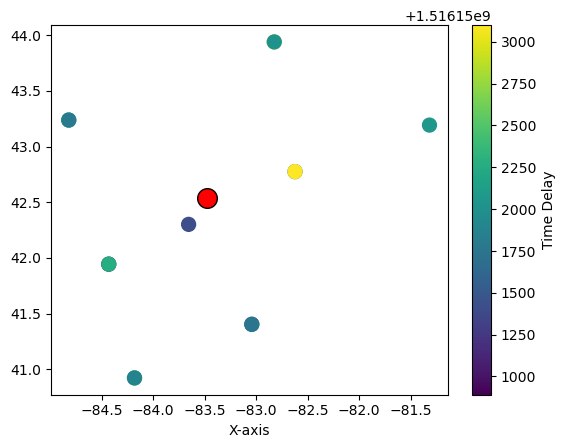

In [70]:
x = []
y = []
for network in inv:
    for station in network:
        for channel in station:
            x += [station.longitude]
            y += [station.latitude]

scatter = plt.scatter(x, y, c=time_delay, cmap='viridis', s=100)

# Add a colorbar to show the mapping of values to colors
plt.colorbar(scatter, label='Time Delay')
plt.scatter(-83.481, 42.538, c='red', s=200, edgecolors='black', label='Epicenter')
# Add labels and title
plt.xlabel('X-axis')

In [35]:
# X,y,azimuth,elevation, time, velocity of fireball

#needs latitude,longtitude, elevation, Initial time of shock (DTCDateTime)
print(final_array)
print(final_array[0,3])

[[ 4.39400000e+01 -8.28246000e+01  2.17000000e+02  1.51615206e+09]
 [ 4.39400000e+01 -8.28246000e+01  2.17000000e+02  1.51615202e+09]
 [ 4.32382000e+01 -8.48214000e+01  2.36000000e+02  1.51615202e+09]
 [ 4.32382000e+01 -8.48214000e+01  2.36000000e+02  1.51615314e+09]
 [ 4.27749000e+01 -8.26231000e+01  1.91000000e+02  1.51615179e+09]
 [ 4.27749000e+01 -8.26231000e+01  1.91000000e+02  1.51615162e+09]
 [ 4.19438020e+01 -8.44328990e+01  3.69000000e+02  1.51615166e+09]
 [ 4.19438020e+01 -8.44328990e+01  3.69000000e+02  1.51615192e+09]
 [ 4.14035000e+01 -8.30428000e+01  1.76000000e+02  1.51615226e+09]
 [ 4.14035000e+01 -8.30428000e+01  1.76000000e+02  1.51615175e+09]
 [ 4.09220000e+01 -8.41825000e+01  2.25000000e+02  1.51615175e+09]
 [ 4.09220000e+01 -8.41825000e+01  2.25000000e+02  1.51615239e+09]
 [ 4.23012000e+01 -8.36567000e+01  1.72000000e+02  1.51615309e+09]
 [ 4.31930010e+01 -8.13163070e+01  2.98000000e+02  1.51615142e+09]]
1516152064.66


In [14]:
for trace in st:
    # The start time of the trace (first time stamp)
    start_time = trace.stats.starttime
    
    # Print the start time
    print(f"Trace: {trace.id} | First timestamp: {start_time}")

Trace: WU.ELFO..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.I49A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.I49A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.J47A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.J47A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.K50A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.K50A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.L48A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.L48A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.M50A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.M50A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: N4.N49A..HHZ | First timestamp: 2018-01-17T00:54:02.260000Z
Trace: N4.N49A.EP.BDF | First timestamp: 2018-01-17T00:54:02.271000Z
Trace: US.AAM.00.BHZ | First timestamp: 2018-01-17T00:54:02.275000Z


In [60]:
def get_values(st,inv):
    time_delay = np.array([])  # Initialize an empty array for time delays
    times_not = np.array([])
    final_array = np.zeros((len(st),4))
    ind = 0
    start_time_array = np.zeros(0)
    for trace in st:
        times = trace.times()  # Get the time values for the trace
        datetime_times = [trace.stats.starttime + t for t in times]
        data = trace.data  # Get the data from the trace
        data = np.abs(data)  # Take the absolute value of the data
        index = np.argmax(data)  # Find the index of the maximum absolute value
        
        # Append the corresponding time to the time_delay array
        time_delay = np.append(time_delay, datetime_times[index])
        times_not = np.append(times_not, times[index])
        start_time_array = np.append(start_time_array, datetime_times[index])
        final_array[ind,3] = times[index]
        ind += 1


    datetimes_as_int = start_time_array.astype('float')

    # Calculate the average of the datetime values (in nanoseconds)
    average_datetime_int = np.mean(datetimes_as_int)


    average_datetime = obspy.UTCDateTime(average_datetime_int)
    ind = -1
    for network in inv:
        for station in network:
            for channel in station:
                ind += 1

                # Get latitude and longitude
                latitude = station.latitude
                final_array[ind,0] = latitude
                longitude = station.longitude
                final_array[ind,1] = longitude
                final_array[ind,2] = station.elevation
    
    return final_array, average_datetime

In [61]:
array, time = get_values(st,inv)

In [ ]:
def get_data(name):
    st = obspy.read(name + "/waveforms/*.mseed")
    inv = obspy.read_inventory(name + "/stations/*.xml")
    st.merge(fill_value='interpolate')
    st.detrend('demean')
    st.detrend('linear')
    st.resample(10.0)
    st.taper(0.05)
    for trace in st:
        trace.filter('bandpass', freqmin=2.4,freqmax=4.4, corners = 2, zerophase = True)
        trace.normalize()
    
    return st,inv